# For Kaggle & Colab

In [1]:
!pip install gdown
!mkdir Dataset
!gdown --id 1dhyuRqNWLP0a7KGor3Tc0VuMzIgs1DZ- -O ./Dataset/twitter.csv

  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - done
  Created wheel for gdown: filename=gdown-3.14.0-py3-none-any.whl size=10044 sha256=aadb3f7c8726f44a483763054ea532189084479db5eef91d83aa033e773e0ad6
  Stored in directory: /root/.cache/pip/wheels/ee/cf/ac/e3ff09ceeea4bf7ff64b04de426caf3a8d0d1a299346ca54fd
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1dhyuRqNWLP0a7KGor3Tc0VuMzIgs1DZ-
To: /kaggle/working/Dataset/twitter.csv
136MB [00:00, 194MB/s]


# Imports

In [2]:
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get Data

In [3]:
# DATASET_COLUMNS=['target', 'id', 'date', 'flag', 'user','text']
# DATASET_ENCODING = "ISO-8859-1"
# df = pd.read_csv("./Dataset/tweets.csv", encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
# df = df[['text', 'target']]
# # df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
# df.to_csv('./Dataset/twitter.csv')

In [4]:
df = pd.read_csv('./Dataset/twitter.csv', index_col=0)

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,4
1599996,TheWDB.com - Very cool to hear old Walt interv...,4
1599997,Are you ready for your MoJo Makeover? Ask me f...,4
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4


# Data Preprocessing

In [6]:
def remove_mentions(text):
    return ' '.join(word for word in text.split(' ') if not  word.startswith('http'))

In [7]:
text = df['text'].apply((lambda x: re.sub('@', '', x))).apply((lambda x: re.sub('#', '', x))).apply((lambda x: re.sub('&', ' and ', x))).apply(remove_mentions).apply((lambda x: re.sub('[^a-zA-z0-9\s]',' ',x))).apply((lambda x: re.sub('\s+', ' ', x)))
df['text'] = text
df['target'] = df['target'].replace(4,1)
df

,text,target
0,switchfoot Awww that s a bummer You shoulda go...,0
1,is upset that he can t update his Facebook by ...,0
2,Kenichan I dived many times for the ball Manag...,0
3,my whole body feels itchy and like its on fire,0
4,nationwideclass no it s not behaving at all i ...,0
...,...,...
1599995,Just woke up Having no school is the best feel...,1
1599996,TheWDB com Very cool to hear old Walt interviews,1
1599997,Are you ready for your MoJo Makeover Ask me fo...,1
1599998,Happy 38th Birthday to my boo of alll time Tup...,1


# Data Visualization

<BarContainer object of 2 artists>

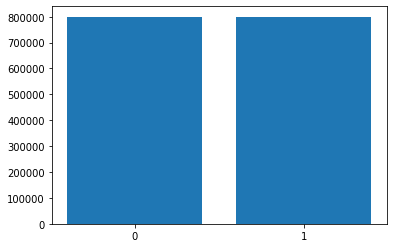

In [8]:
target = df['target'].to_numpy()
uniq, cnts = np.unique(target, return_counts=True)
uniq = [str(i) for i in uniq]
plt.bar(uniq, cnts)

# Shuffle & Split Data

In [9]:
train = np.concatenate((df.text.to_numpy().reshape(-1, 1), df.target.to_numpy().reshape(-1, 1)), axis=-1)
np.random.shuffle(train)
val = train[int(0.7*train.shape[0]):, :]
train = train[:int(0.7*train.shape[0]), :]
train.shape, val.shape

((1120000, 2), (480000, 2))

# Tokenize Data

## Initialize & Fit Tokenizer

In [10]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train[:, 0])

## Train Set

In [11]:
encoded_tweets_train = tokenizer.texts_to_sequences(train[:, 0])
pad_en_tweets_train = pad_sequences(encoded_tweets_train)
max_features = len(tokenizer.word_index) + 1
train_labels = np.asarray(train[:, 1]).astype('int32')

## Validation Set

In [12]:
encoded_tweets_val = tokenizer.texts_to_sequences(val[:, 0])
pad_en_tweets_val = pad_sequences(encoded_tweets_val)
val_labels = np.asarray(val[:, 1]).astype('int32')

# Training

## Create Model

In [13]:
embedding_vector_length = 64

model = Sequential(
    [
        layers.Embedding(max_features, embedding_vector_length, input_length=pad_en_tweets_train.shape[1]),
        layers.Bidirectional(layers.LSTM(128)),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid'),
    ]
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 98, 64)            30358784  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 30,557,697
Trainable params: 30,557,185
Non-trainable params: 512
_________________________________________________________________


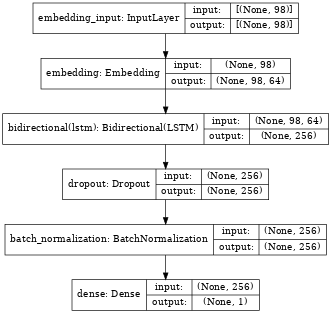

In [14]:
keras.utils.plot_model(model, show_shapes=True, dpi=48)

## Fit Model

In [15]:
epochs = 5
batch_size = 8000
X = tf.convert_to_tensor(pad_en_tweets_train)
Y = tf.cast(train_labels.reshape(-1, 1), tf.int32)
history = model.fit(pad_en_tweets_train, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(pad_en_tweets_val, val_labels))
history

Epoch 1/5
140/140 [==============================] - 123s 776ms/step - loss: 0.5329 - auc: 0.7967 - val_loss: 0.6459 - val_auc: 0.8816
Epoch 2/5
140/140 [==============================] - 108s 769ms/step - loss: 0.3792 - auc: 0.9115 - val_loss: 0.5739 - val_auc: 0.8815
Epoch 3/5
140/140 [==============================] - 107s 765ms/step - loss: 0.3029 - auc: 0.9437 - val_loss: 0.4879 - val_auc: 0.8749
Epoch 4/5
140/140 [==============================] - 108s 768ms/step - loss: 0.2524 - auc: 0.9609 - val_loss: 0.4520 - val_auc: 0.8731
Epoch 5/5
140/140 [==============================] - 107s 768ms/step - loss: 0.2198 - auc: 0.9703 - val_loss: 0.5066 - val_auc: 0.8680


## Visualize Training

### Plot Loss

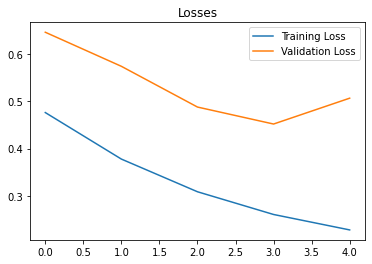

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Losses')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

### Plot AUC ROC

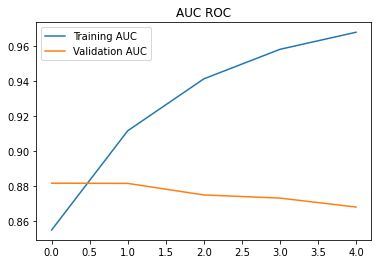

In [17]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('AUC ROC')
plt.legend(['Training AUC', 'Validation AUC'])
plt.show()

# Save Model

In [18]:
model.save('Sentiment')
with open('history.pickle', 'wb') as output_file:
    pickle.dump(history.history, output_file)

## Zip Model For Easy Download

In [19]:
!zip -r sentiment.zip Sentiment

  adding: Sentiment/ (stored 0%)
  adding: Sentiment/variables/ (stored 0%)
  adding: Sentiment/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: Sentiment/variables/variables.index (deflated 66%)
  adding: Sentiment/assets/ (stored 0%)
  adding: Sentiment/saved_model.pb (deflated 90%)


# Testing

In [20]:
model = tf.keras.models.load_model('Sentiment')
preds = model.predict(pad_en_tweets_val)
dframe = pd.DataFrame()
dframe['tweet'] = val[:, 0]
dframe['true'] = val_labels
dframe['preds'] = np.round(preds)
dframe

,tweet,true,preds
0,fannywu Here is a shoulder Keep it Rose loves ...,1,1.0
1,movie night on saturdaaaaaaay think the best f...,1,1.0
2,dmariev,1,1.0
3,looking at designs for garden office got a nic...,1,1.0
4,careyshair that s insane Too bad I just bought...,0,0.0
...,...,...,...
479995,brittanynichole 3 for students 5 for adults,1,1.0
479996,kcvikander haha i had no idea what you were re...,0,0.0
479997,UPS doesn t pick up on Saturday s Still gettin...,1,0.0
479998,tired i would love to see metro station todaay...,0,0.0
